# 学習するroundにより、predictがどのように変化するかの確認

In [32]:
!pip install numerapi -qq
!pip install numpy-indexed -qq

In [1]:
from pathlib import Path
import pickle
import json

from IPython import embed
import numerapi
from numerapi import NumerAPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import numpy_indexed as npi
import warnings
warnings.simplefilter('ignore')
plt.style.use('fivethirtyeight')

napi = numerapi.NumerAPI(verbosity="info")
current_round = napi.get_current_round()  # 現在のroundを取得
print('current_round', current_round)


def sizeof_fmt(num, suffix='B'):
    """読みやすいように単位をつける"""
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


def get_memory_usage_from_df(df: pd.DataFrame):
    """dataframeのサイズを返す"""
    return sizeof_fmt(df.memory_usage(index=True).sum())     


def get_massive_data(mode: str, round: int):
    """
    mode: training, validation, tournament
    round: ラウンド数
    """
    parquet_path = Path(f'{mode}_data_int8_{current_round}.parquet')
    if not parquet_path.is_file():
        napi.download_dataset(filename=f"numerai_{mode}_data_int8.parquet",
                              dest_path=str(parquet_path),
                              round_num=round)
    df = pd.read_parquet(f'{mode}_data_int8_{current_round}.parquet')
    return df

current_round 301


## データの取得

In [8]:
train = get_massive_data('training', current_round)
valid = get_massive_data('validation', current_round)
napi.download_dataset('features.json', 'features.json')
with open("features.json", "r") as f:
    feature_metadata = json.load(f)
    
print('train:', get_memory_usage_from_df(train), train.shape)
print('valid:', get_memory_usage_from_df(valid), valid.shape)

2022-02-03 18:02:39,761 INFO numerapi.utils: starting download


features.json:   0%|          | 0.00/441k [00:00<?, ?B/s]

features.json:   4%|▍         | 17.4k/441k [00:00<00:02, 154kB/s]

features.json:  12%|█▏        | 52.2k/441k [00:00<00:02, 182kB/s]

features.json:  28%|██▊       | 122k/441k [00:00<00:01, 231kB/s] 

features.json: 441kB [00:00, 924kB/s]                           
training_data_int8_301.parquet:   8%|▊         | 83.3M/1.01G [08:49<1:38:30, 157kB/s]

train: 2.6GiB (2412105, 1073)
valid: 596.0MiB (539658, 1073)


## targetの割合

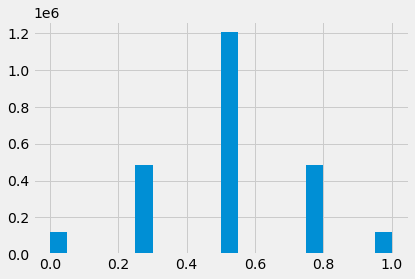

In [9]:
plt.hist(train['target'], bins=20)
plt.show()

## LihgtGBM

In [14]:
features = feature_metadata['feature_sets']['small']
len(features)

38

In [18]:
class CFG:
    target_col = 'target'


lgb_params = {'objective': 'regression',
              'metric': 'None',
              'first_metric_only': True,
              'boosting_type': 'gbdt',
              "num_leaves": 63,
              "max_depth": 6,
              'learning_rate': 0.03, 
              'min_data_in_leaf': 100,
              'verbosity': -1
              }


def compute_corr_for_lgb(preds, target):
    # validの全体の平均を返すmetric
    preds_rank = pd.Series(preds).rank(pct=True, method="first")
    corr = np.corrcoef(preds_rank, target.get_label())[0, 1]
    return 'corr', corr, True


def single_lgb(train, valid, features, params, feval=None):

    d_train = lgb.Dataset(train[features].values,
                          train[CFG.target_col].values,
                          feature_name=features)
    d_eval = lgb.Dataset(valid[features].values,
                         valid[CFG.target_col].values,
                         feature_name=features)
    evals_result = {}
    model = lgb.train(params,
                      d_train,
                      num_boost_round=10000,
                      valid_sets=[d_train, d_eval],
                      early_stopping_rounds=None,
                      evals_result=evals_result,
                      verbose_eval=300,
                      feval=feval)
    return model, evals_result

In [19]:
class MetricCorr:
    def __init__(self, era_group: pd.Series):
        self.group = npi.group_by(era_group.values)

    def corrs(self, preds, target):
        labels = self.group.split(target)
        preds_rank = [pd.Series(p).rank(pct=True, method="first").values for p in self.group.split(preds)]
        corr_list = [np.corrcoef(preds, rank)[0, 1] for preds, rank in zip(preds_rank, labels)]
        return corr_list

    def corr_mean_lgb(self, preds: np.ndarray, data: lgb.Dataset):
        labels = self.group.split(data.get_label())
        preds_rank = [pd.Series(p).rank(pct=True, method="first").values for p in self.group.split(preds)]
        corr_mean = np.mean([np.corrcoef(preds, rank)[0, 1] for preds, rank in zip(preds_rank, labels)])
        return 'corr_mean', corr_mean, True

    def corr_mean_xgb(self, preds: np.ndarray, data: xgb.DMatrix):
        # https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html#customized-metric-function
        labels = self.group.split(data.get_label())
        preds_rank = [pd.Series(p).rank(pct=True, method="first").values for p in self.group.split(preds)]
        corr_mean = np.mean([np.corrcoef(preds, rank)[0, 1] for preds, rank in zip(preds_rank, labels)])
        return 'corr_mean', corr_mean

In [20]:
metric = MetricCorr(valid['era'])
model, evals_result = single_lgb(train, valid, features, lgb_params, metric.corr_mean_lgb)

[300]	training's corr_mean: 0.120404	valid_1's corr_mean: 0.0214845
[600]	training's corr_mean: 0.149998	valid_1's corr_mean: 0.0222325
[900]	training's corr_mean: 0.172813	valid_1's corr_mean: 0.0223343
[1200]	training's corr_mean: 0.192804	valid_1's corr_mean: 0.0224258
[1500]	training's corr_mean: 0.210161	valid_1's corr_mean: 0.021533
[1800]	training's corr_mean: 0.225268	valid_1's corr_mean: 0.0211431
[2100]	training's corr_mean: 0.239177	valid_1's corr_mean: 0.0210369
[2400]	training's corr_mean: 0.251252	valid_1's corr_mean: 0.0204807
[2700]	training's corr_mean: 0.262604	valid_1's corr_mean: 0.0199965
[3000]	training's corr_mean: 0.273046	valid_1's corr_mean: 0.0197943
[3300]	training's corr_mean: 0.283128	valid_1's corr_mean: 0.0194786
[3600]	training's corr_mean: 0.291961	valid_1's corr_mean: 0.0198657
[3900]	training's corr_mean: 0.300388	valid_1's corr_mean: 0.0197961
[4200]	training's corr_mean: 0.308973	valid_1's corr_mean: 0.0192796
[4500]	training's corr_mean: 0.3167	va

## roundを変えてpredictを出す

In [23]:
round_list = [100, 500, 1000, 3000, 5000, 10000]
val_pred_list = []

for num_round in round_list:
    val_pred_list.append(model.predict(valid[features], num_iteration=num_round))

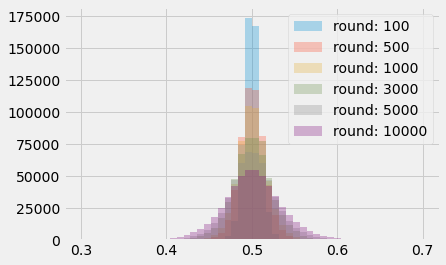

In [28]:
for pred, num_round in zip(val_pred_list, round_list):
    plt.hist(pred, label=f'round: {num_round}', alpha=0.3 ,bins=50, range=(0.3, 0.7))
plt.legend()

In [38]:
metric = MetricCorr(valid['era'])
metric_list = []
for i in range(6):
   metric_list.append(np.mean(metric.corrs(valid['target'], val_pred_list[i])))

In [42]:
metric_list

[0.018303046912392082,
 0.02123383898947741,
 0.02161743235488168,
 0.019682810439717556,
 0.018014592302132086,
 0.015970691481497264]

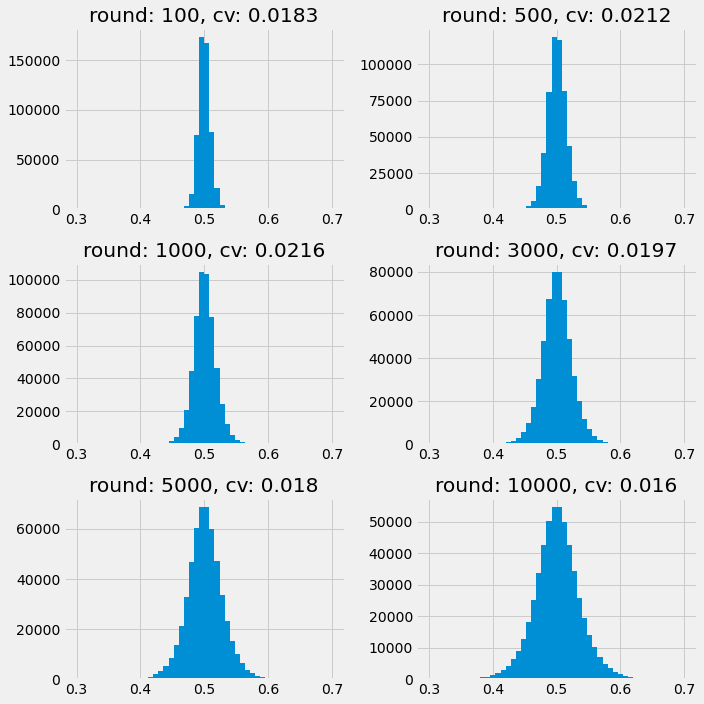

In [46]:
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.hist(val_pred_list[i], bins=50, range=(0.3, 0.7))
    plt.title(f'round: {round_list[i]}, cv: {np.round(metric_list[i], 4)}')
plt.tight_layout()